In [1]:
import os

import basd
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import scipy.stats as sps
import seaborn as sns
import xarray as xr

### Exploring the `xarray` package

   - Creating two `DataArray`s, affectively dataframes with extra attributes
        - One for precipitation and one for temperature at 4 grid cells
   - Adding these two `DataArray`s to a `Dataset`, more or less a dictionary for these data

In [2]:
# Precipitation data array
pr = xr.DataArray( np.random.rand(2,2), dims=('lat','lon'), coords={'lat':[35,10]})
pr.attrs['long_name'] = 'precipitation'
pr.attrs['units'] = 'inches'
pr.attrs['description'] = 'mean precipitation of grid cell, daily'

# Temperature data array
tas = xr.DataArray( np.random.rand(2,2), dims=('lat','lon'), coords={'lat':[35,10]})
tas.attrs['long_name'] = 'precipitation'
tas.attrs['units'] = 'inches'
tas.attrs['description'] = 'mean precipitation of grid cell, daily'

# Dataset of the two above data arrays
dataset = xr.Dataset(dict(pr=pr, tas=tas))

#### Reading in a NetCDF file

Reading in observational precipitation data from 1979-2014 supplied in the data directory.

In [3]:
pr_obs_hist = xr.open_dataset('../basd/data/pr_obs-hist_coarse_1979-2014.nc')
pr_sim_hist = xr.open_dataset('../basd/data/pr_sim-hist_coarse_1979-2014.nc')
pr_sim_fut = xr.open_dataset('../basd/data/pr_sim-fut_coarse_2065-2100.nc')

## Running a Bias Adjustment

### Initializing our first `Adjustment` object

Here we are providing the three required data arrays and the variable name 'pr'. For precipitation, a variable that will be bounded below, we want to input some additional parameters:

- Lower bound = 0
- Lower threshold = 0.001
- Trend preservation = mixed
- Distribution = gamma

Otherwise, we are keeping the default parameter values for the bias adjustment

In [5]:
params = basd.Parameters(lower_bound=0, lower_threshold=0.0000011574,
                         trend_preservation='mixed', distribution='gamma')
ba = basd.Adjustment(pr_obs_hist, pr_sim_hist, pr_sim_fut, 'pr', params)

#### Initializing running window mode

Here we want to scrape the month, year, or day of the year, for each observation.

We will actually only use the years and months as we are using running window mode, but this demonstrates how to get all three.

In [6]:
ba.adjust_bias_one_location(tuple([0, 0]))

# Scraping the time from the data and turning into pandas date time array
dates_obs_hist = pd.DatetimeIndex(ba.obs_hist['time'].values)
dates_sim_hist = pd.DatetimeIndex(ba.sim_hist['time'].values)
dates_sim_fut = pd.DatetimeIndex(ba.sim_fut['time'].values)

# Getting the month for each observation
month_numbers = {
    'obs_hist': dates_obs_hist.month,
    'sim_hist': dates_sim_hist.month,
    'sim_fut': dates_sim_fut.month
}

# Getting the year for each observation
years = {
    'obs_hist': dates_obs_hist.year,
    'sim_hist': dates_sim_hist.year,
    'sim_fut': dates_sim_fut.year
}

# Getting the day of the year for each observation
days = {
    'obs_hist': dates_obs_hist.day_of_year,
    'sim_hist': dates_sim_hist.day_of_year,
    'sim_fut': dates_sim_fut.day_of_year
}

# Get window centers for running window mode
if ba.step_size:
    days_max = np.max(days['sim_fut'])
    days_mod = days_max % ba.step_size
    days_center_first = 1 + ba.step_size // 2
    # make sure first and last window have the sane length (+/-1)
    if days_mod: days_center_first -= (ba.step_size - days_mod) // 2
    days_center = np.arange(days_center_first, days_max+1, ba.step_size)


TypeError: map_quantiles_non_parametric_trend_preserving() missing 1 required positional argument: 'x_sim_fut'

In [8]:
data_shape = tuple([ba.obs_hist.dims['lat'], ba.obs_hist.dims['lon']])
i_loc = tuple([1,1])

#### Extracting data from given location
These are time series for the given variable, here precipitation, at the location index (1,1). In this case that's 52.5 degrees North, 13.5 degrees east, daily from Jan 1, 1979 to Dec 31, 2014.

In [10]:
obs_hist_loc = ba.obs_hist['pr'][i_loc]
sim_hist_loc = ba.sim_hist['pr'][i_loc]
sim_fut_loc = ba.sim_fut['pr'][i_loc]

xarray.core.dataarray.DataArray

#### Plotting input data for single location

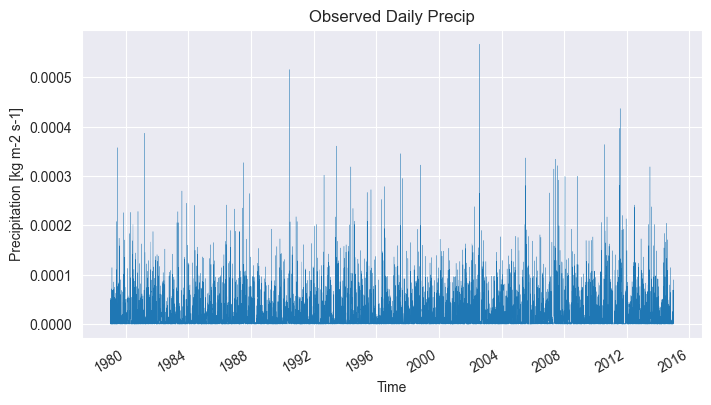

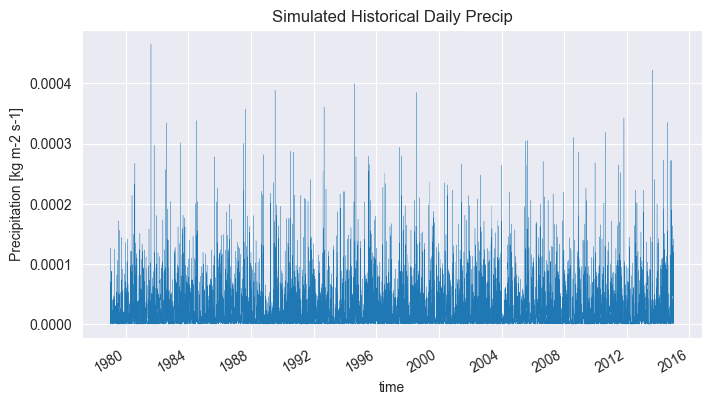

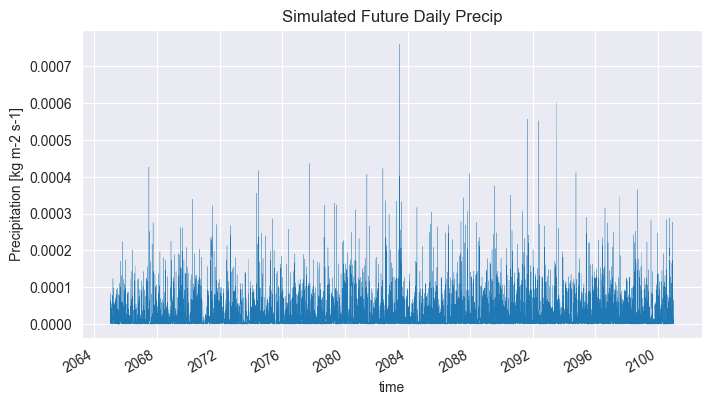

In [43]:
obs_hist_loc.plot.line(x="time",marker=None,linewidth=0.2,aspect=2,size=4)
plt.title('Observed Daily Precip')
plt.show()

sim_hist_loc.plot.line(x="time",marker=None,linewidth=0.2,aspect=2,size=4)
plt.title('Simulated Historical Daily Precip')
plt.show()

sim_fut_loc.plot.line(x="time",marker=None,linewidth=0.2,aspect=2,size=4)
plt.title('Simulated Future Daily Precip')
plt.show()


In [44]:
ohdf = ba.obs_hist['pr'].to_dataframe().reset_index()
shdf = ba.sim_hist['pr'].to_dataframe().reset_index()
sfdf = ba.sim_fut['pr'].to_dataframe().reset_index()

ohdf['group'] = 'Observed Historical'
shdf['group'] = 'Simulated Historical'
sfdf['group'] = 'Simulated Future'

df = pd.concat([ohdf,shdf,sfdf], ignore_index=True)

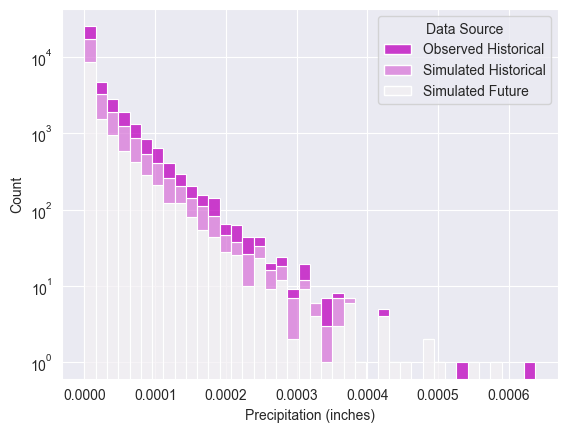

In [45]:
plot_data = df[(df['lon'] == 12.5) & (df['lat'] == 53.5)]

p = sns.histplot(data=plot_data, x='pr', hue='group',
              multiple='stack', palette="light:m_r", bins = 40 )
p.set_yscale('log')
p.set_xlabel('Precipitation (inches)')
p.get_legend().set_title('Data Source')
plt.show()

#### Computing mean value over all time steps

In [46]:
long_term_mean = {
    'obs_hist': basd.average_valid_values( obs_hist_loc.values, np.nan,
                                           ba.lower_bound, ba.lower_threshold,
                                           ba.upper_bound, ba.upper_threshold),
    'sim_hist': basd.average_valid_values( sim_hist_loc.values, np.nan,
                                           ba.lower_bound, ba.lower_threshold,
                                           ba.upper_bound, ba.upper_threshold),
    'sim_fut': basd.average_valid_values( sim_fut_loc.values, np.nan,
                                          ba.lower_bound, ba.lower_threshold,
                                          ba.upper_bound, ba.upper_threshold)
}
long_term_mean

{'obs_hist': 1.982811e-05, 'sim_hist': 2.2349104e-05, 'sim_fut': 2.2766604e-05}

#### Local Bias Adjustment
Here this is specific to running window mode

In [67]:
window_centers = days_center
years_this_window = {}
data_this_window = {}
data = {
    'obs_hist': obs_hist_loc,
    'sim_hist': sim_hist_loc,
    'sim_fut': sim_fut_loc
}

# Adjustment for each window
for window_center in window_centers:
    for key, data_arr in data.items():
        # Get indices for data needed for this window
        m = basd.window_indices_for_running_bias_adjustment( days[key], window_center, 31 )
        # Associated year for each data point in the resulting data
        years_this_window[key] = years[key][m]
        # Sample invalid values
        replaced, invalid = basd.sample_invalid_values(data_arr.values[m],1,long_term_mean[key])
        # The actual needed data in this window
        data_this_window[key] = replaced

    for key, y in years.items():
        # Option to detrend here
        # No matter what, randomize censored values
        basd.randomize_censored_values( data_this_window[key], ba.lower_bound, ba.lower_threshold, ba.upper_bound, ba.upper_threshold,True,False,1)
        type(data_this_window[key])

    basd.map_qualntiles_parametric_trend_preserving(
        data_this_window['obs_hist'], data_this_window['sim_hist'], data_this_window['sim_fut'])

    # Do bias adjustment on window
print(type(data_arr.values[m]))
print(type(replaced))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


#### Time to Adjust bias for individual window

In [75]:
x = np.random.randn(100)
fitted_params = {
    'normal': sps.norm.fit(x),
    'rice': sps.rice.fit(x),
    'gamma': sps.gamma.fit(x),
    'weibull': sps.weibull_min.fit(x)
}
ps = sps.norm.cdf(np.random.randn(100), *fitted_params['normal'])
sps.norm.ppf(ps, *fitted_params['normal'])

array([ 2.21860401,  0.25424343, -0.976213  ,  0.13065298, -0.45960242,
        0.6833984 , -1.16001849,  1.25275955, -1.2986801 ,  0.63349052,
        1.64023771,  0.84090637,  0.36578021,  0.56194783,  0.51511664,
       -0.71098083,  1.5519318 , -0.63702107,  0.1215643 ,  1.08909286,
       -0.15858981,  1.42060557,  0.1255358 ,  0.29827927, -0.59039051,
        1.58779544,  0.57075081, -1.04644172,  1.06693943, -0.06289951,
        0.28236334,  1.16356333,  0.21119251, -0.59442815,  1.36503952,
        0.87806438,  1.50415256, -1.4659883 ,  1.14401322, -0.44580136,
       -0.70312425, -2.02193311, -1.99110817,  0.65903534,  0.39090662,
        1.47680736,  1.01640386,  0.46097919,  0.75589159,  0.29043934,
       -0.55790374, -0.27345656,  1.23280874,  0.15017001, -0.95182957,
        0.36302364,  1.07595247, -0.66627579, -2.1390084 , -1.0781576 ,
       -0.68826404, -0.01894332,  0.55637746, -0.42322906,  1.5379023 ,
        1.23222222,  2.32889638,  1.21084961, -0.05176634, -1.77